In [1]:
import pandas as pd
import numpy as np

In [2]:
intRate = pd.read_excel('./data/sample.xlsx', dtype={'BASE_DATE': str})
intRate['BASE_DATE'] = pd.to_datetime(intRate['BASE_DATE'])

In [6]:
#1. 데이터 가공하기
matCd = np.sort(intRate['MAT_CD'].unique())
mat = np.array([int(m.replace('M', '')) for m in matCd])/12
baseDate = np.sort(intRate['BASE_DATE'].unique())

n = baseDate.shape[0]
m = matCd.shape[0]

ktbRate = np.zeros([n, m])
kdbRate = np.zeros([n, m])

a100 = intRate.query('IR_CURVE_ID == "A100"')
e110 = intRate.query('IR_CURVE_ID == "E110"')
for i in range(len(matCd)):
    ktbRate[:, i] = a100.query('MAT_CD == @matCd[@i]').sort_values(by='BASE_DATE')['INT_RATE']
    kdbRate[:, i] = e110.query('MAT_CD == @matCd[@i]').sort_values(by='BASE_DATE')['INT_RATE']

In [71]:
class CoveredBond:
    def __init__(self, baseDate, mat, ktbRate, kdbRate):
        self.mat = mat
        self.ktbRate = ktbRate
        self.kdbRate = kdbRate
        self.baseDate = baseDate
        
        self.n = ktbRate.shape[0]
        self.m = ktbRate.shape[1]
        
        self.__calcBeta()
        
    def __calcBeta(self):
        spread = self.kdbRate/self.ktbRate
        spreadAvg = spread.mean(axis=0) - 1
        liqPrem = self.ktbRate[-1, :]*spreadAvg
        liqPrem[0] = liqPrem[-1] = 0
        X = np.array([[1, t, t**2, t**3, t**4] for t in mat])
        self.beta = np.linalg.inv(X.T@X)@X.T@liqPrem
        
    def getLiqPrem(self, t):
        if (t <= 0) | (t >= 20):
            return 0
        else:
            x = np.array([1, t, t**2, t**3, t**4])
            return self.beta@x

In [72]:
cb = CoveredBond(baseDate, mat, ktbRate, kdbRate)

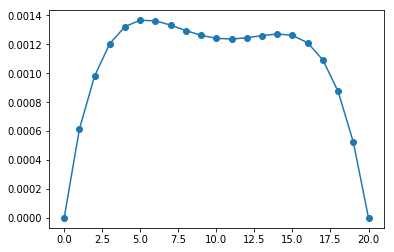

In [67]:
import matplotlib.pyplot as plt

x = range(0, 21)
y = [cb.getLiqPrem(t) for t in x]

plt.plot(x, y, '-o')
plt.show()